# Active Contours (Snakes) Segmentation
## Implementation and Analysis


This notebook implements Active Contours (Snakes) segmentation technique with:
- Image preprocessing and thresholding
- Internal energy implementation (α and β parameters)
- Snake evolution algorithm
- Comprehensive analysis and visualization

## 1. Import Libraries and Setup

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')


## 2. Load Image and Apply Preprocessing

Loading the image and converting it to RGB and Grayscale formats for processing.

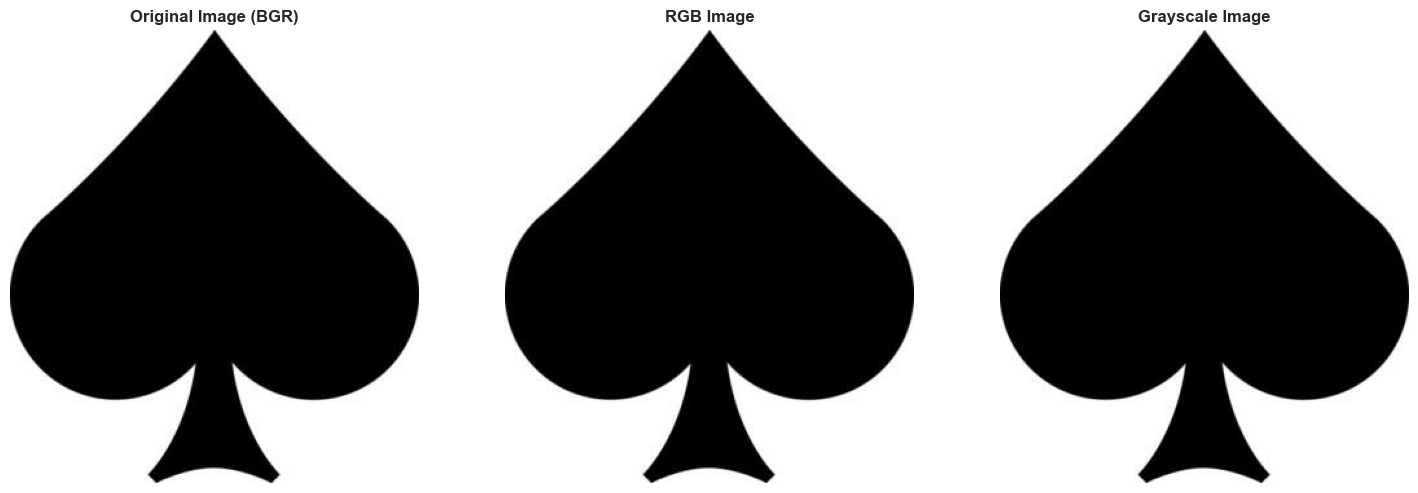

Image Shape (RGB): (350, 316, 3)
Image Shape (Gray): (350, 316)


In [2]:
# Load the image
image_path = 'image.jpg'
image_bgr = cv2.imread(image_path)

if image_bgr is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Convert BGR to RGB (OpenCV loads in BGR format)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Convert to Grayscale
image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

# Display original images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_bgr[:, :, ::-1])  # Convert BGR to RGB for display
axes[0].set_title('Original Image (BGR)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(image_rgb)
axes[1].set_title('RGB Image', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(image_gray, cmap='gray')
axes[2].set_title('Grayscale Image', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Image Shape (RGB): {image_rgb.shape}")
print(f"Image Shape (Gray): {image_gray.shape}")

## 3. Create Binary Thresholded Image

Applying binary thresholding to segment the image into foreground and background.

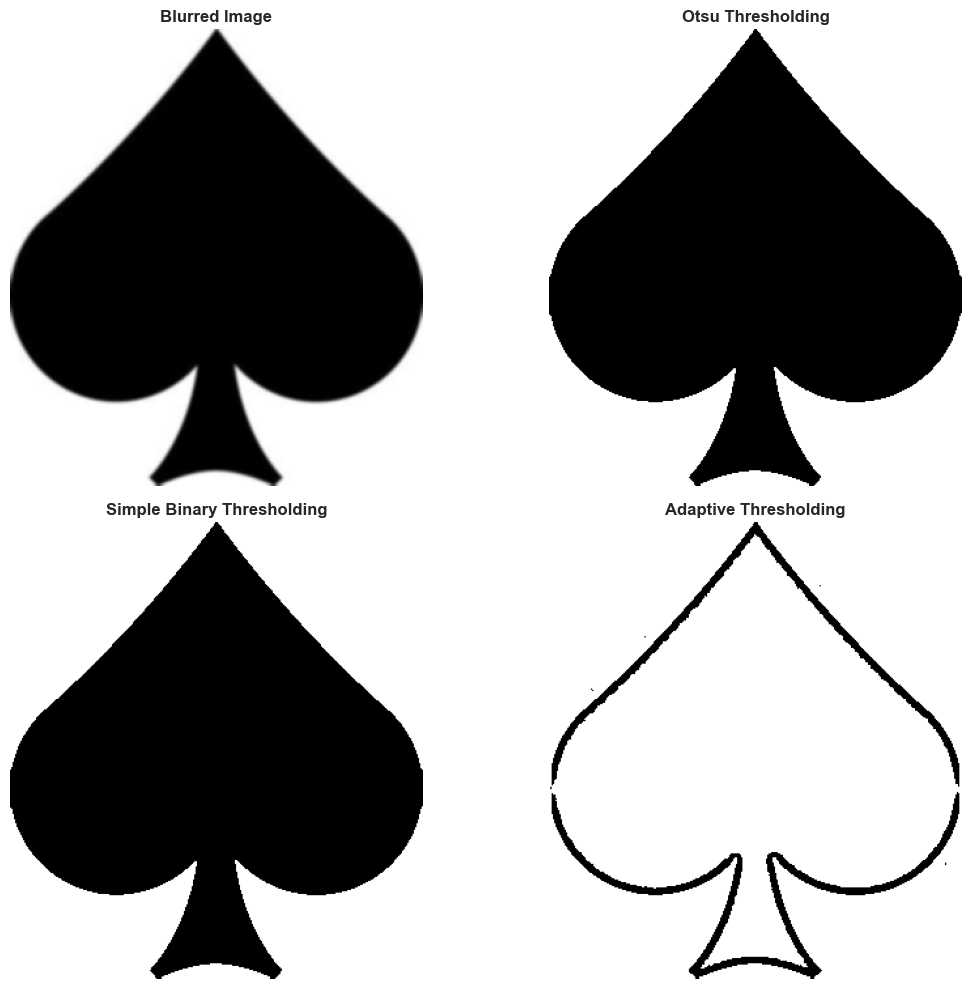

In [3]:
# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)

# Apply Otsu's thresholding (automatic threshold selection)
_, binary_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply simple binary thresholding
_, binary_simple = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

# Apply adaptive thresholding
binary_adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)

# Display thresholded images
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(blurred, cmap='gray')
axes[0, 0].set_title('Blurred Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(binary_otsu, cmap='gray')
axes[0, 1].set_title('Otsu Thresholding', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(binary_simple, cmap='gray')
axes[1, 0].set_title('Simple Binary Thresholding', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(binary_adaptive, cmap='gray')
axes[1, 1].set_title('Adaptive Thresholding', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Use Otsu's method for further processing
binary_image = binary_otsu.copy()

## 4. Find Contours from Thresholded Image

Using OpenCV's built-in function to detect contours.

Number of contours found: 5


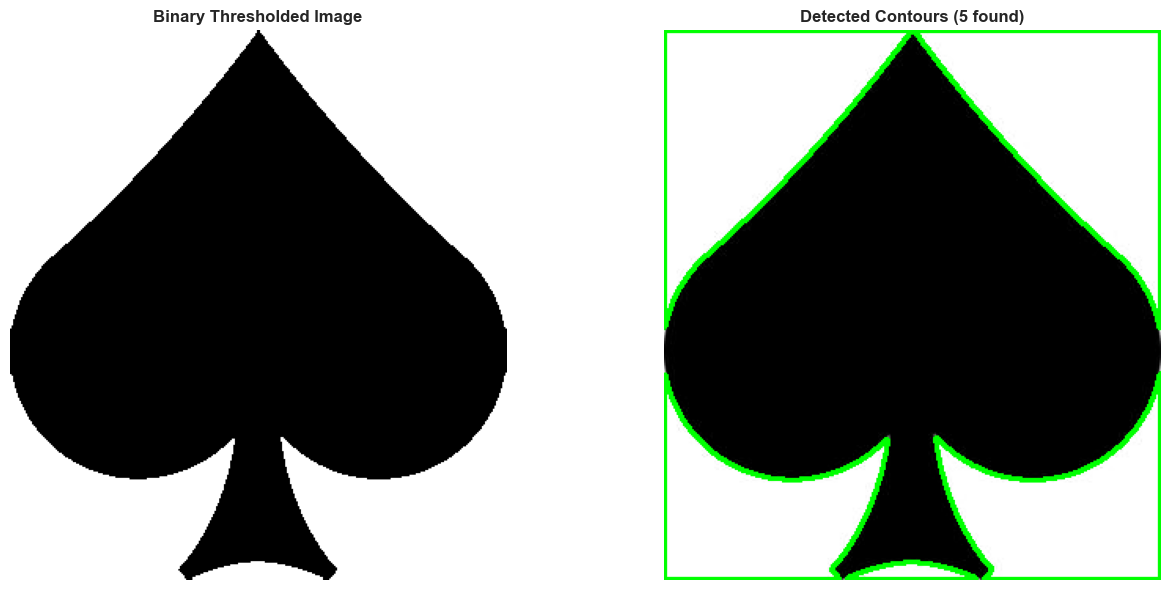

Largest contour area: 14220.50 pixels
Largest contour points: 67


In [4]:
# Find contours using OpenCV (Built-in function)
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Number of contours found: {len(contours)}")

# Draw contours on original image
image_with_contours = image_rgb.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

# Display contours
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(binary_image, cmap='gray')
axes[0].set_title('Binary Thresholded Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(image_with_contours)
axes[1].set_title(f'Detected Contours ({len(contours)} found)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Get the largest contour for snake initialization
if len(contours) > 0:
    largest_contour = max(contours, key=cv2.contourArea)
    print(f"Largest contour area: {cv2.contourArea(largest_contour):.2f} pixels")
    print(f"Largest contour points: {len(largest_contour)}")

## 5. Active Contours (Snake) Implementation

### 5.1 Internal Energy Implementation

The internal energy of a snake consists of two components:

**Elasticity (α):** Controls the stretching of the snake. Higher α makes the snake resist stretching.

**Stiffness/Bending (β):** Controls the bending of the snake. Higher β makes the snake resist bending and prefer smooth curves.

In [5]:
def calculate_elasticity_energy(snake, alpha):
    """
    Calculate elasticity energy (first-order derivative).
    Measures the distance between consecutive points.
    
    Parameters:
    -----------
    snake : ndarray
        Array of snake points (N x 2)
    alpha : float
        Elasticity parameter
    
    Returns:
    --------
    energy : float
        Total elasticity energy
    """
    n = len(snake)
    energy = 0
    
    for i in range(n):
        # Distance between consecutive points (circular)
        diff = snake[i] - snake[(i - 1) % n]
        energy += alpha * np.sum(diff ** 2)
    
    return energy


def calculate_stiffness_energy(snake, beta):
    """
    Calculate stiffness/bending energy (second-order derivative).
    Measures the curvature at each point.
    
    Parameters:
    -----------
    snake : ndarray
        Array of snake points (N x 2)
    beta : float
        Stiffness parameter
    
    Returns:
    --------
    energy : float
        Total stiffness energy
    """
    n = len(snake)
    energy = 0
    
    for i in range(n):
        # Second derivative (curvature)
        prev_point = snake[(i - 1) % n]
        curr_point = snake[i]
        next_point = snake[(i + 1) % n]
        
        curvature = prev_point - 2 * curr_point + next_point
        energy += beta * np.sum(curvature ** 2)
    
    return energy


def calculate_internal_energy(snake, alpha, beta):
    """
    Calculate total internal energy of the snake.
    
    E_internal = E_elasticity + E_stiffness
    """
    elasticity = calculate_elasticity_energy(snake, alpha)
    stiffness = calculate_stiffness_energy(snake, beta)
    
    return elasticity + stiffness


# Test the energy functions
test_snake = np.array([[100, 100], [150, 100], [150, 150], [100, 150]])
test_alpha = 0.1
test_beta = 0.1

print("Internal Energy Components:")
print(f"Elasticity Energy (α={test_alpha}): {calculate_elasticity_energy(test_snake, test_alpha):.4f}")
print(f"Stiffness Energy (β={test_beta}): {calculate_stiffness_energy(test_snake, test_beta):.4f}")
print(f"Total Internal Energy: {calculate_internal_energy(test_snake, test_alpha, test_beta):.4f}")

Internal Energy Components:
Elasticity Energy (α=0.1): 1000.0000
Stiffness Energy (β=0.1): 2000.0000
Total Internal Energy: 3000.0000


### 5.2 Construct Internal Energy Matrix

The internal energy matrix is used to efficiently compute the snake evolution. It's a pentadiagonal matrix that encodes the elasticity and stiffness constraints.

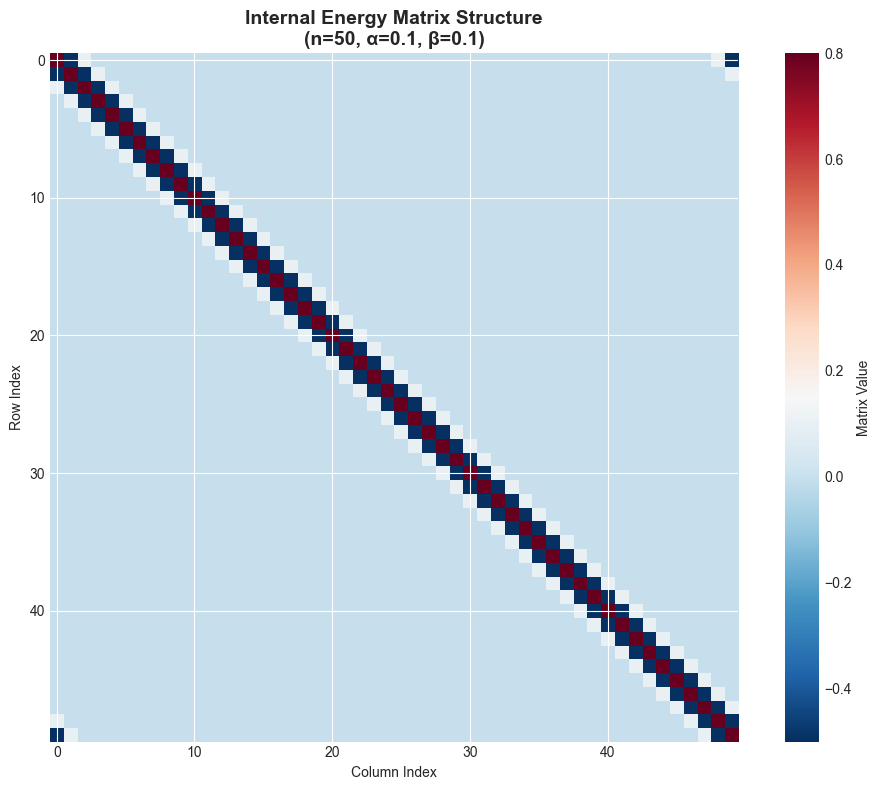

Matrix Shape: (50, 50)
Matrix is pentadiagonal: True

Sample row (showing pentadiagonal structure):
[ 0.8 -0.5  0.1  0.   0.   0.   0.   0.   0.   0. ]


In [6]:
def construct_internal_energy_matrix(n_points, alpha, beta):
    """
    Construct the internal energy matrix for snake evolution.
    
    The matrix is pentadiagonal and represents the discrete approximation
    of the internal energy functional.
    
    Parameters:
    -----------
    n_points : int
        Number of points in the snake
    alpha : float
        Elasticity parameter
    beta : float
        Stiffness parameter
    
    Returns:
    --------
    A : ndarray
        Internal energy matrix (n_points x n_points)
    """
    # Initialize matrix
    A = np.zeros((n_points, n_points))
    
    for i in range(n_points):
        # Diagonal elements
        A[i, i] = 2 * alpha + 6 * beta
        
        # First off-diagonal (elasticity)
        A[i, (i - 1) % n_points] += -alpha - 4 * beta
        A[i, (i + 1) % n_points] += -alpha - 4 * beta
        
        # Second off-diagonal (stiffness)
        A[i, (i - 2) % n_points] += beta
        A[i, (i + 2) % n_points] += beta
    
    return A


# Construct and visualize the internal energy matrix
n_points = 50
alpha = 0.1
beta = 0.1

A_matrix = construct_internal_energy_matrix(n_points, alpha, beta)

# Visualize the matrix structure
plt.figure(figsize=(10, 8))
plt.imshow(A_matrix, cmap='RdBu_r', interpolation='nearest')
plt.colorbar(label='Matrix Value')
plt.title(f'Internal Energy Matrix Structure\n(n={n_points}, α={alpha}, β={beta})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

print(f"Matrix Shape: {A_matrix.shape}")
print(f"Matrix is pentadiagonal: {np.allclose(A_matrix, A_matrix.T)}")
print(f"\nSample row (showing pentadiagonal structure):")
print(A_matrix[0, :10])

### 5.3 External Energy (Image Forces)

External energy attracts the snake to image features like edges.

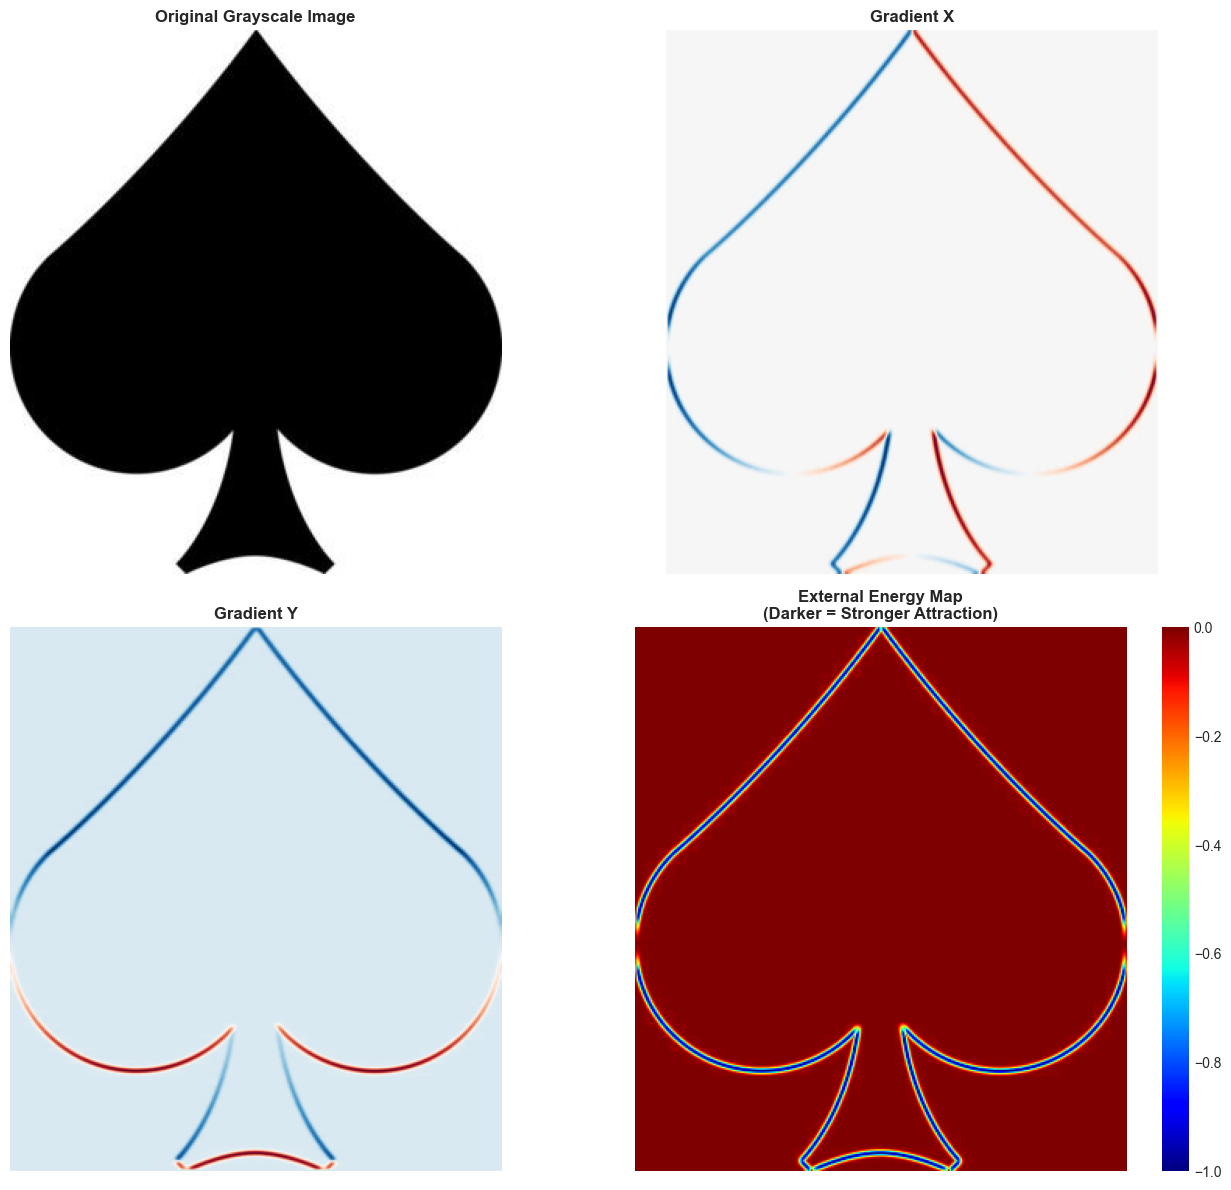

In [7]:
def compute_external_energy(image):
    """
    Compute external energy map from image gradients.
    Uses edge detection to create an energy field.
    
    Parameters:
    -----------
    image : ndarray
        Grayscale image
    
    Returns:
    --------
    energy_map : ndarray
        External energy map
    """
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 1.0)
    
    # Compute gradients
    grad_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    
    # Gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Normalize to [0, 1]
    gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / \
                         (gradient_magnitude.max() - gradient_magnitude.min() + 1e-8)
    
    # Negative gradient (snake attracted to high gradients)
    energy_map = -gradient_magnitude
    
    return energy_map, grad_x, grad_y


# Compute external energy
external_energy, grad_x, grad_y = compute_external_energy(image_gray)

# Visualize external energy
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('Original Grayscale Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(grad_x, cmap='RdBu_r')
axes[0, 1].set_title('Gradient X', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(grad_y, cmap='RdBu_r')
axes[1, 0].set_title('Gradient Y', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

im = axes[1, 1].imshow(external_energy, cmap='jet')
axes[1, 1].set_title('External Energy Map\n(Darker = Stronger Attraction)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

### 5.4 Snake Evolution Algorithm

Implementing the complete snake evolution with iterative optimization.

In [8]:
def initialize_snake_circle(center, radius, n_points):
    """
    Initialize snake as a circle.
    
    Parameters:
    -----------
    center : tuple
        (x, y) center coordinates
    radius : float
        Circle radius
    n_points : int
        Number of points on the snake
    
    Returns:
    --------
    snake : ndarray
        Initial snake points (n_points x 2)
    """
    angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    
    return np.column_stack([x, y])


def get_external_force(snake, external_energy, grad_x, grad_y):
    """
    Calculate external forces at snake points using bilinear interpolation.
    """
    forces = np.zeros_like(snake)
    
    for i, (x, y) in enumerate(snake):
        # Ensure coordinates are within image bounds
        x_int = int(np.clip(x, 0, grad_x.shape[1] - 1))
        y_int = int(np.clip(y, 0, grad_x.shape[0] - 1))
        
        # Get gradient at this point
        forces[i, 0] = grad_x[y_int, x_int]
        forces[i, 1] = grad_y[y_int, x_int]
    
    return forces


def evolve_snake(snake, external_energy, grad_x, grad_y, alpha, beta, 
                 gamma, n_iterations, display_interval=10):
    """
    Evolve the snake using gradient descent.
    
    Parameters:
    -----------
    snake : ndarray
        Initial snake points
    external_energy : ndarray
        External energy map
    grad_x, grad_y : ndarray
        Image gradients
    alpha : float
        Elasticity parameter
    beta : float
        Stiffness parameter
    gamma : float
        Step size for gradient descent
    n_iterations : int
        Number of iterations
    display_interval : int
        Interval for saving snake states
    
    Returns:
    --------
    snake : ndarray
        Final snake points
    snake_history : list
        List of snake states at display intervals
    """
    n_points = len(snake)
    snake = snake.copy()
    snake_history = [snake.copy()]
    
    # Construct internal energy matrix
    A = construct_internal_energy_matrix(n_points, alpha, beta)
    
    # Invert matrix for efficient computation
    # Add identity matrix for numerical stability
    A_inv = np.linalg.inv(A + gamma * np.eye(n_points))
    
    for iteration in range(n_iterations):
        # Get external forces
        external_forces = get_external_force(snake, external_energy, grad_x, grad_y)
        
        # Update snake position
        # x_new = (A + γI)^(-1) * (γx + f_external)
        snake_x = A_inv @ (gamma * snake[:, 0] + external_forces[:, 0])
        snake_y = A_inv @ (gamma * snake[:, 1] + external_forces[:, 1])
        
        snake = np.column_stack([snake_x, snake_y])
        
        # Save snake state at intervals
        if (iteration + 1) % display_interval == 0:
            snake_history.append(snake.copy())
    
    return snake, snake_history


print("Snake evolution functions defined successfully!")

Snake evolution functions defined successfully!


## 6. Run Snake Evolution and Display Results

### 6.1 Initialize Snake and Run Evolution

In [9]:
# Get image dimensions
height, width = image_gray.shape

# Initialize snake (circle in the center)
center = (width // 2, height // 2)
radius = min(width, height) // 4
n_points = 100

initial_snake = initialize_snake_circle(center, radius, n_points)

# Snake parameters
alpha = 0.015   # Elasticity
beta = 0.05     # Stiffness
gamma = 0.1    # Step size
n_iterations = 250
display_interval = 25

print("Snake Parameters:")
print(f"  α (Elasticity): {alpha}")
print(f"  β (Stiffness): {beta}")
print(f"  γ (Step size): {gamma}")
print(f"  Number of points: {n_points}")
print(f"  Iterations: {n_iterations}")
print(f"\nInitial snake center: {center}")
print(f"Initial snake radius: {radius}")
print(f"\nRunning snake evolution...")

# Run snake evolution
final_snake, snake_history = evolve_snake(
    initial_snake, external_energy, grad_x, grad_y,
    alpha, beta, gamma, n_iterations, display_interval
)

print(f"Evolution complete! Saved {len(snake_history)} snapshots.")

Snake Parameters:
  α (Elasticity): 0.015
  β (Stiffness): 0.05
  γ (Step size): 0.1
  Number of points: 100
  Iterations: 250

Initial snake center: (158, 175)
Initial snake radius: 79

Running snake evolution...
Evolution complete! Saved 11 snapshots.


### 6.2 Display Snake Evolution Over Iterations

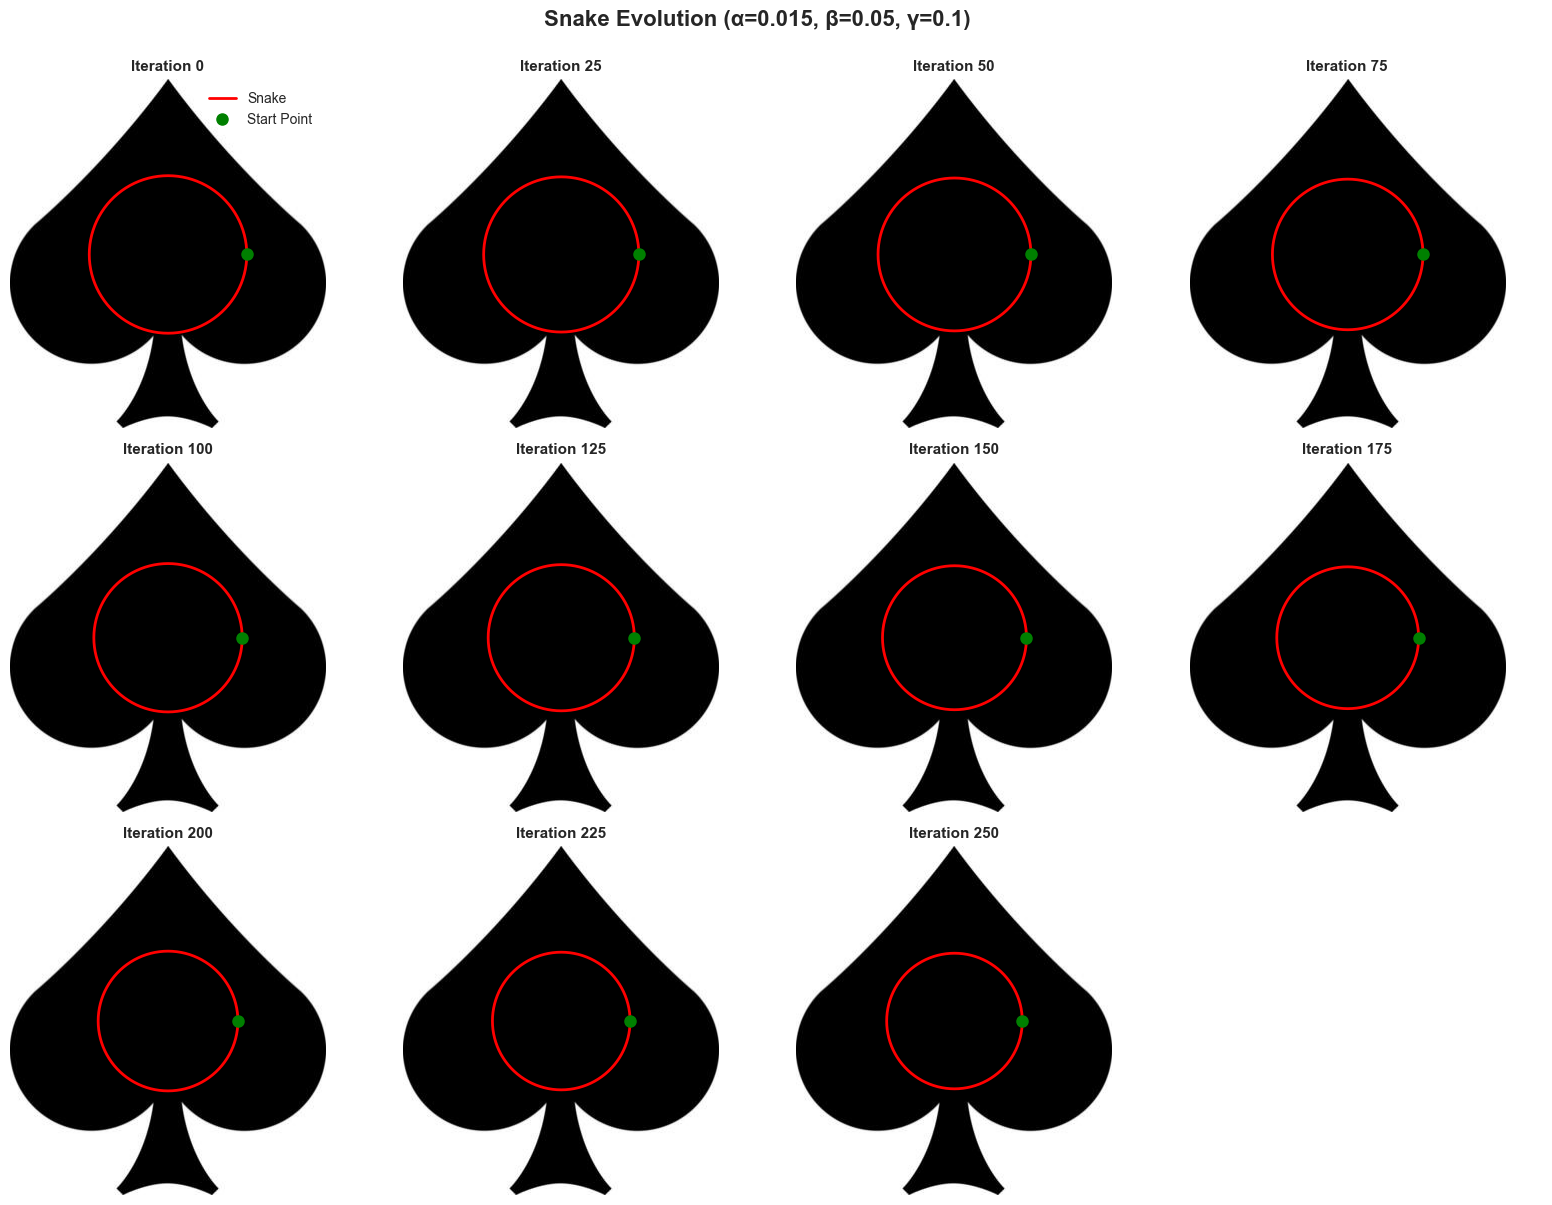

In [10]:
# Display snake evolution
n_snapshots = len(snake_history)
n_cols = 4
n_rows = (n_snapshots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten() if n_snapshots > 1 else [axes]

for idx, snake in enumerate(snake_history):
    iteration = idx * display_interval
    
    axes[idx].imshow(image_rgb)
    axes[idx].plot(snake[:, 0], snake[:, 1], 'r-', linewidth=2, label='Snake')
    axes[idx].plot(snake[0, 0], snake[0, 1], 'go', markersize=8, label='Start Point')
    axes[idx].set_title(f'Iteration {iteration}', fontsize=11, fontweight='bold')
    axes[idx].axis('off')
    if idx == 0:
        axes[idx].legend(loc='upper right')

# Hide unused subplots
for idx in range(n_snapshots, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Snake Evolution (α={alpha}, β={beta}, γ={gamma})', 
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

### 6.3 Compare Initial and Final Snake

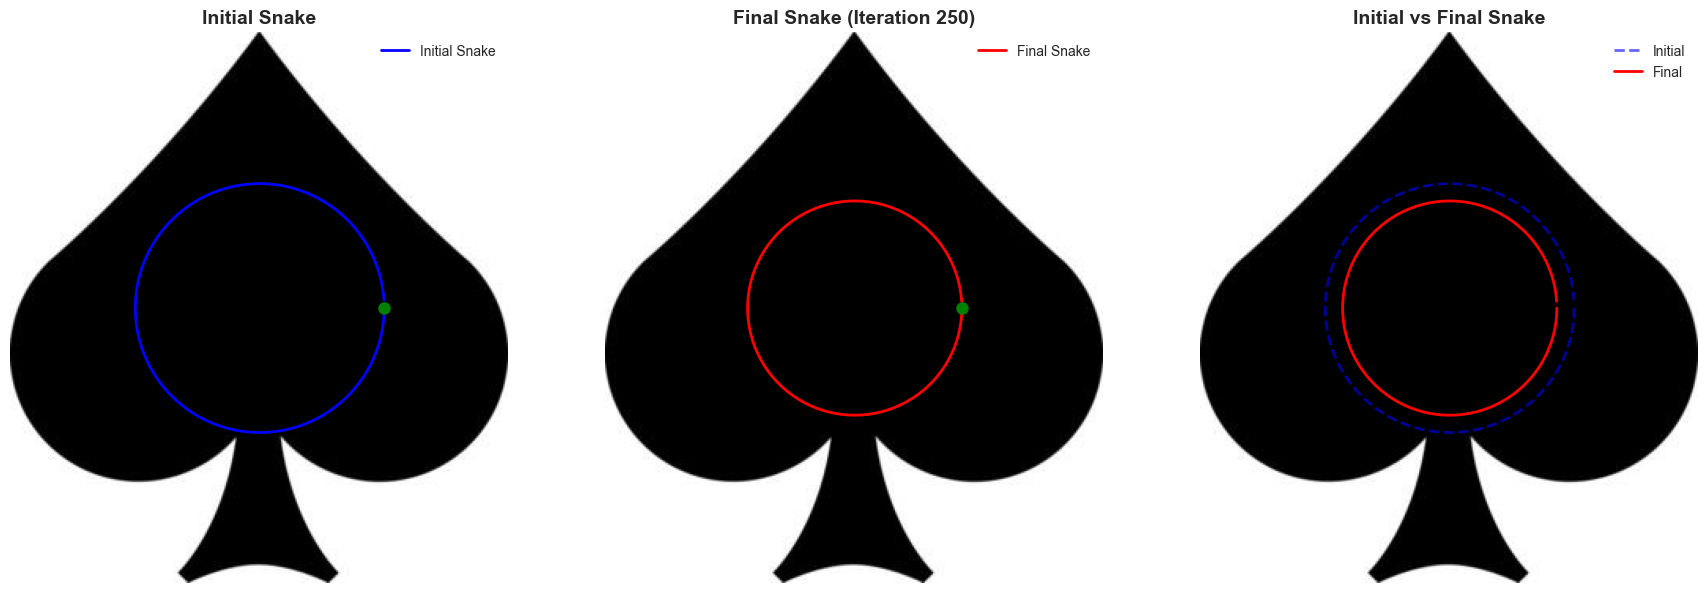

In [11]:
# Compare initial and final snake
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Initial snake
axes[0].imshow(image_rgb)
axes[0].plot(initial_snake[:, 0], initial_snake[:, 1], 'b-', linewidth=2, label='Initial Snake')
axes[0].plot(initial_snake[0, 0], initial_snake[0, 1], 'go', markersize=8)
axes[0].set_title('Initial Snake', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].axis('off')

# Final snake
axes[1].imshow(image_rgb)
axes[1].plot(final_snake[:, 0], final_snake[:, 1], 'r-', linewidth=2, label='Final Snake')
axes[1].plot(final_snake[0, 0], final_snake[0, 1], 'go', markersize=8)
axes[1].set_title(f'Final Snake (Iteration {n_iterations})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].axis('off')

# Both overlaid
axes[2].imshow(image_rgb)
axes[2].plot(initial_snake[:, 0], initial_snake[:, 1], 'b--', linewidth=2, 
             label='Initial', alpha=0.6)
axes[2].plot(final_snake[:, 0], final_snake[:, 1], 'r-', linewidth=2, 
             label='Final')
axes[2].set_title('Initial vs Final Snake', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 7. Analysis: Roles of α and β Parameters

### 7.1 Understanding α (Elasticity)

**Role of α:**
- Controls the **stretching** of the snake
- Higher α → Snake resists stretching → Prefers uniform spacing between points
- Lower α → Snake can stretch more freely → Points can cluster

**Mathematical Formulation:**
$$E_{elasticity} = \alpha \sum_{i=1}^{n} |v_i - v_{i-1}|^2$$

where $v_i$ are the snake vertices.

### 7.2 Understanding β (Stiffness/Bending)

**Role of β:**
- Controls the **bending** or curvature of the snake
- Higher β → Snake resists bending → Prefers smooth, straight contours
- Lower β → Snake can bend more freely → Can follow sharp corners

**Mathematical Formulation:**
$$E_{stiffness} = \beta \sum_{i=1}^{n} |v_{i-1} - 2v_i + v_{i+1}|^2$$

Testing different α values (elasticity):
  Running with α = 0.001...
  Running with α = 0.01...
  Running with α = 0.05...
  Running with α = 0.2...


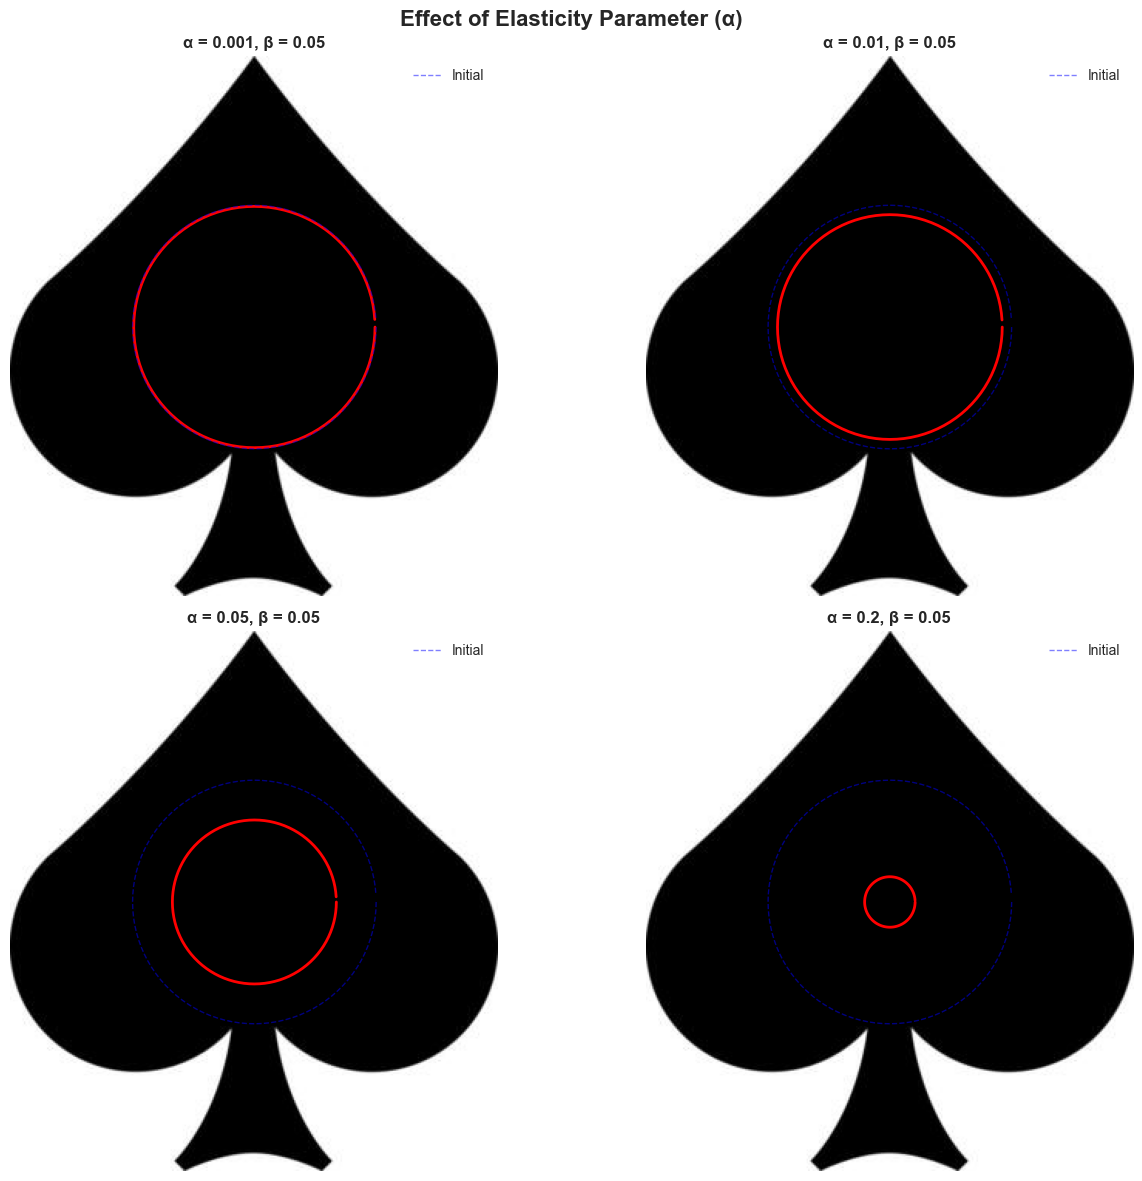

Done!


In [12]:
# Demonstrate the effect of different α values
alpha_values = [0.001, 0.01, 0.05, 0.2]
beta_fixed = 0.05
n_iter_demo = 200

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

print("Testing different α values (elasticity):")
for idx, alpha_test in enumerate(alpha_values):
    print(f"  Running with α = {alpha_test}...")
    
    snake_test, _ = evolve_snake(
        initial_snake, external_energy, grad_x, grad_y,
        alpha_test, beta_fixed, gamma, n_iter_demo, display_interval=50
    )
    
    axes[idx].imshow(image_rgb)
    axes[idx].plot(snake_test[:, 0], snake_test[:, 1], 'r-', linewidth=2)
    axes[idx].plot(initial_snake[:, 0], initial_snake[:, 1], 'b--', 
                   linewidth=1, alpha=0.5, label='Initial')
    axes[idx].set_title(f'α = {alpha_test}, β = {beta_fixed}', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].axis('off')

plt.suptitle('Effect of Elasticity Parameter (α)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Done!")

Testing different β values (stiffness):
  Running with β = 0.001...
  Running with β = 0.01...
  Running with β = 0.05...
  Running with β = 0.2...


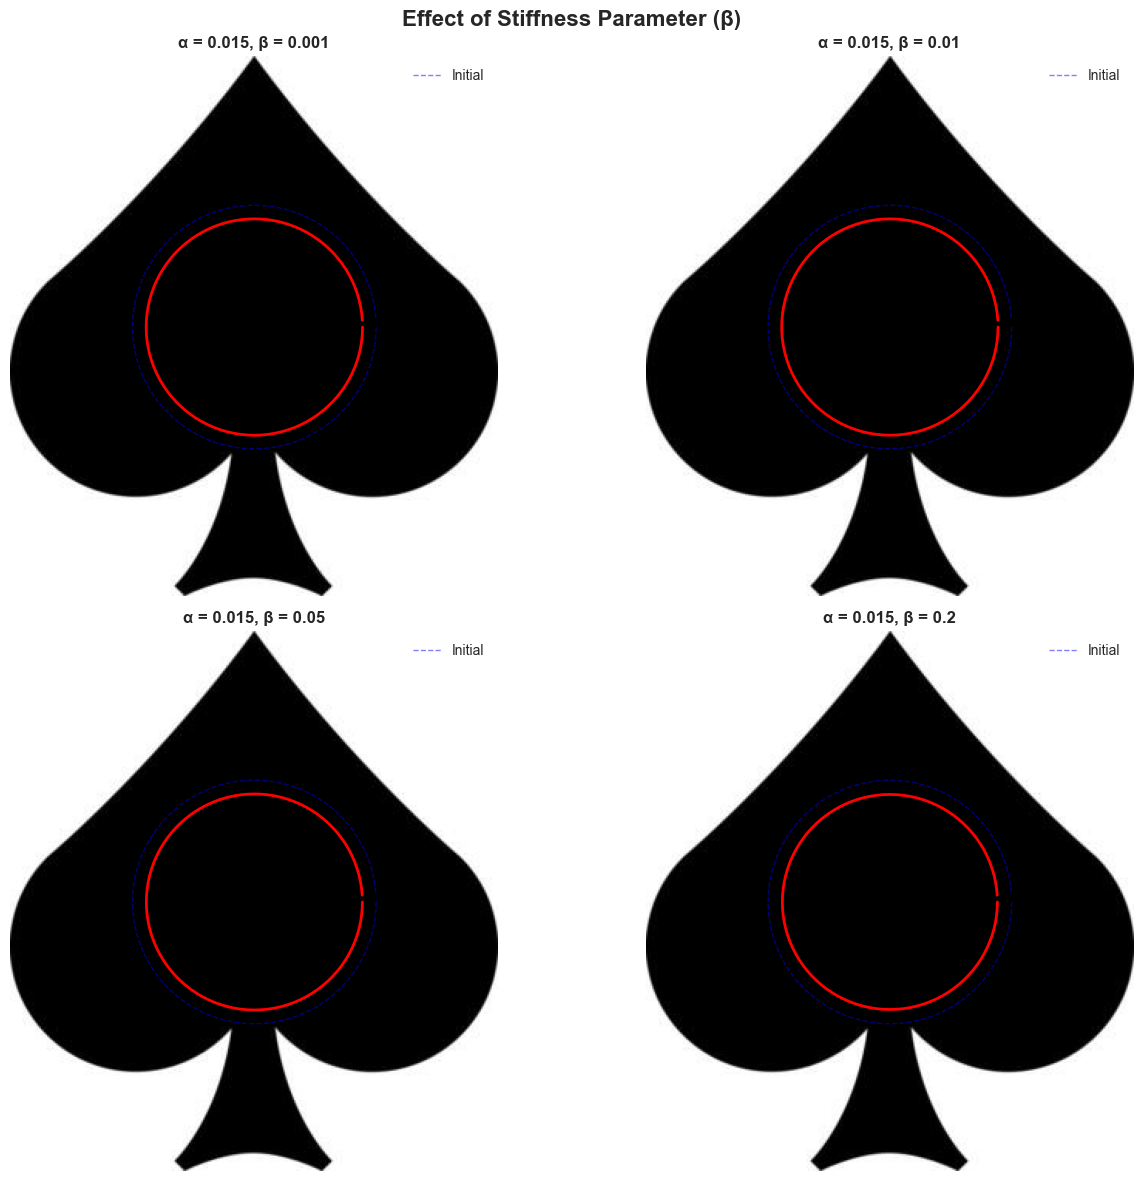

Done!


In [13]:
# Demonstrate the effect of different β values
beta_values = [0.001, 0.01, 0.05, 0.2]
alpha_fixed = 0.015

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

print("Testing different β values (stiffness):")
for idx, beta_test in enumerate(beta_values):
    print(f"  Running with β = {beta_test}...")
    
    snake_test, _ = evolve_snake(
        initial_snake, external_energy, grad_x, grad_y,
        alpha_fixed, beta_test, gamma, n_iter_demo, display_interval=50
    )
    
    axes[idx].imshow(image_rgb)
    axes[idx].plot(snake_test[:, 0], snake_test[:, 1], 'r-', linewidth=2)
    axes[idx].plot(initial_snake[:, 0], initial_snake[:, 1], 'b--', 
                   linewidth=1, alpha=0.5, label='Initial')
    axes[idx].set_title(f'α = {alpha_fixed}, β = {beta_test}', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].axis('off')

plt.suptitle('Effect of Stiffness Parameter (β)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Done!")

## 8. Analysis: Effects of Extreme Parameter Values

### 8.1 When α is Too Large

**Problems:**
- Snake becomes **too rigid** and resists stretching
- Cannot adapt to object boundaries of varying sizes
- May get stuck in local minima
- Fails to capture fine details

### 8.2 When α is Too Small

**Problems:**
- Snake points can **cluster together**
- Loses uniform distribution of points
- May collapse to a single point
- Unstable evolution

### 8.3 When β is Too Large

**Problems:**
- Snake becomes **too smooth**
- Cannot follow sharp corners or high-curvature boundaries
- Tends to form circular or elliptical shapes
- Misses important geometric features

### 8.4 When β is Too Small

**Problems:**
- Snake can **bend too freely**
- Susceptible to noise and spurious edges
- May develop oscillations or wiggles
- Unstable contour

Testing extreme parameter values:
  α too small: α=0.0001, β=0.1
  α too large: α=1.0, β=0.1
  β too small: α=0.01, β=0.0001
  β too large: α=0.01, β=1.0


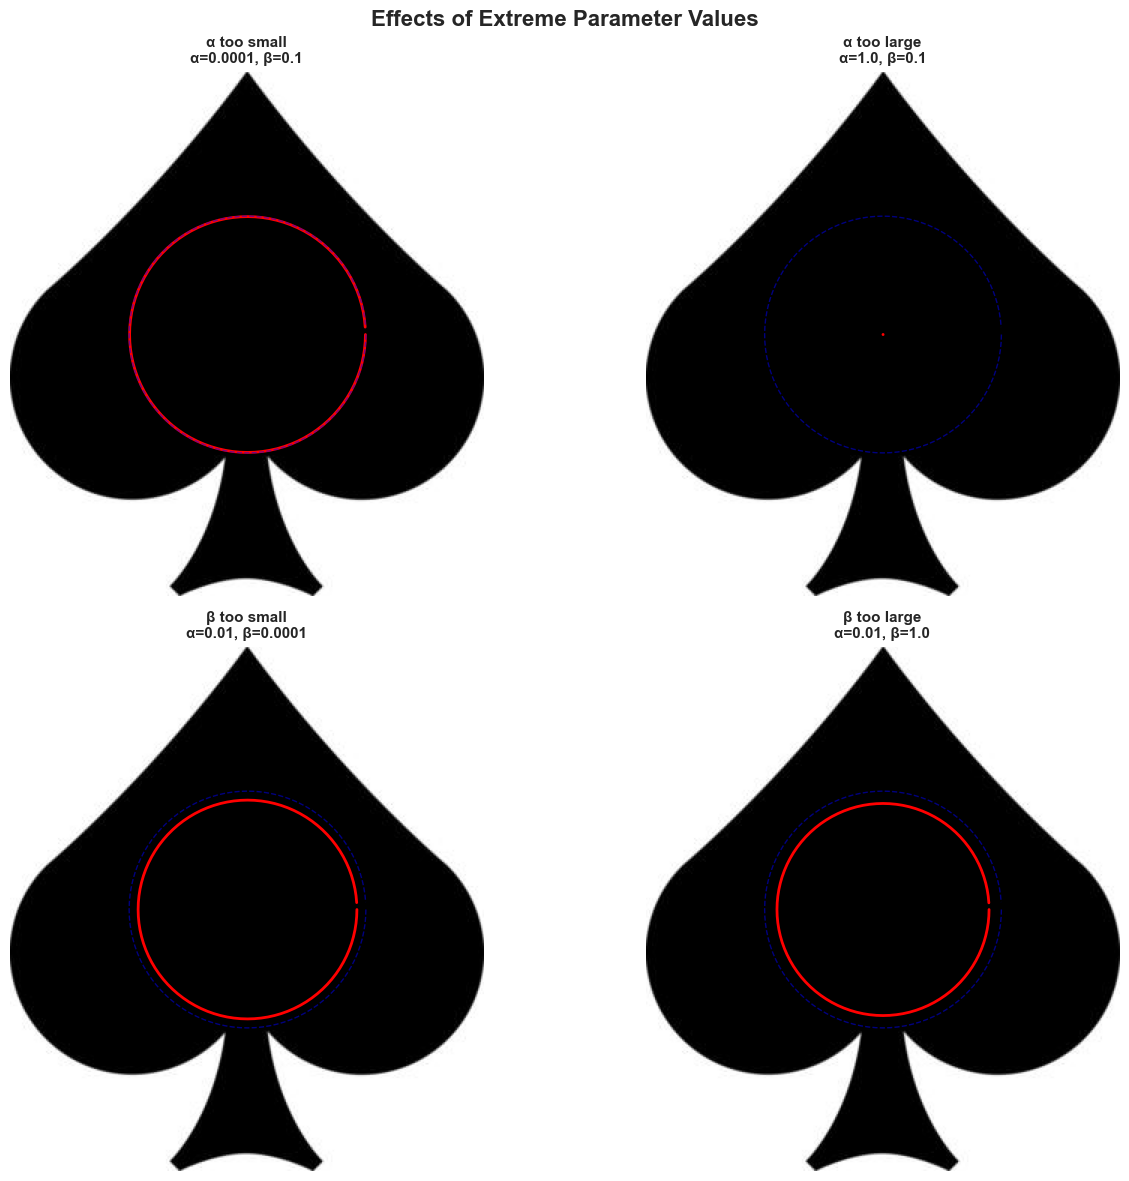

Done!


In [14]:
# Demonstrate extreme parameter values
extreme_params = [
    (0.0001, 0.1, 'α too small'),
    (1.0, 0.1, 'α too large'),
    (0.01, 0.0001, 'β too small'),
    (0.01, 1.0, 'β too large')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

print("Testing extreme parameter values:")
for idx, (alpha_test, beta_test, label) in enumerate(extreme_params):
    print(f"  {label}: α={alpha_test}, β={beta_test}")
    
    try:
        snake_test, _ = evolve_snake(
            initial_snake, external_energy, grad_x, grad_y,
            alpha_test, beta_test, gamma, n_iter_demo, display_interval=50
        )
        
        axes[idx].imshow(image_rgb)
        axes[idx].plot(snake_test[:, 0], snake_test[:, 1], 'r-', linewidth=2)
        axes[idx].plot(initial_snake[:, 0], initial_snake[:, 1], 'b--', 
                       linewidth=1, alpha=0.5)
        axes[idx].set_title(f'{label}\nα={alpha_test}, β={beta_test}', 
                            fontsize=11, fontweight='bold')
    except Exception as e:
        axes[idx].text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
                       ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{label} - FAILED', fontsize=11, fontweight='bold', color='red')
    
    axes[idx].axis('off')

plt.suptitle('Effects of Extreme Parameter Values', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Done!")

## 9. Analysis: Initialization Problems

### 9.1 Problems When Snake Starts Far from Object Boundary

**Key Issues:**

1. **Weak External Forces:**
   - Far from edges, gradient magnitudes are small
   - Snake receives weak guidance toward the boundary
   - May converge very slowly or not at all

2. **Local Minima:**
   - Snake may get trapped by nearby spurious edges
   - Cannot escape local minima to reach the true boundary
   - Final result depends heavily on initialization

3. **Capture Range:**
   - Traditional snakes have limited **capture range**
   - Only effective when initialized near the target boundary
   - Typically requires manual initialization

4. **Convergence Issues:**
   - May require many more iterations
   - Computational cost increases significantly
   - May never converge to the desired boundary
<!-- 
**Solutions:**
- Use **Gradient Vector Flow (GVF)** for larger capture range
- Apply **multi-scale** approaches
- Use **balloon forces** to push snake outward/inward
- Initialize using automatic methods (e.g., from thresholding) -->

Testing different initialization distances:
  Very Close: radius=39
  Close: radius=79
  Medium: radius=105
  Far: radius=126.0


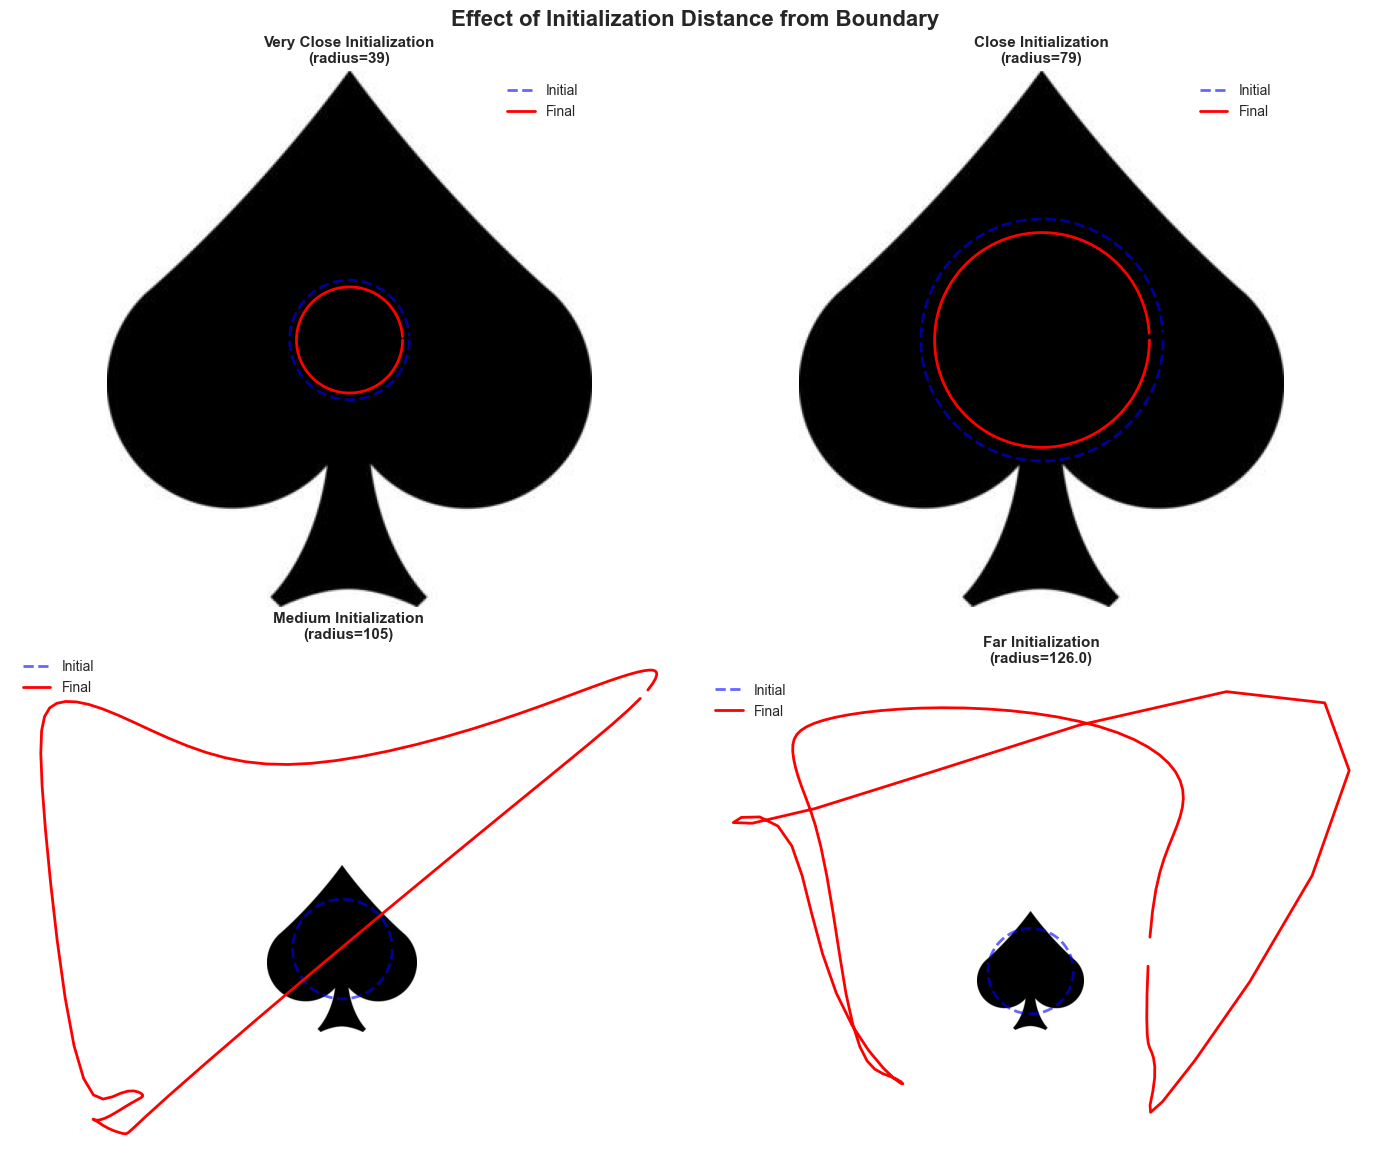

Done!


In [15]:
# Demonstrate initialization at different distances
radii = [min(width, height) // 8, min(width, height) // 4, 
         min(width, height) // 3, min(width, height) // 2.5]
labels = ['Very Close', 'Close', 'Medium', 'Far']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

print("Testing different initialization distances:")
for idx, (radius_test, label) in enumerate(zip(radii, labels)):
    print(f"  {label}: radius={radius_test}")
    
    # Initialize snake at different distance
    init_snake = initialize_snake_circle(center, radius_test, n_points)
    
    # Evolve snake
    snake_test, _ = evolve_snake(
        init_snake, external_energy, grad_x, grad_y,
        alpha, beta, gamma, n_iter_demo, display_interval=50
    )
    
    axes[idx].imshow(image_rgb)
    axes[idx].plot(init_snake[:, 0], init_snake[:, 1], 'b--', 
                   linewidth=2, alpha=0.6, label='Initial')
    axes[idx].plot(snake_test[:, 0], snake_test[:, 1], 'r-', 
                   linewidth=2, label='Final')
    axes[idx].set_title(f'{label} Initialization\n(radius={radius_test})', 
                        fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].axis('off')

plt.suptitle('Effect of Initialization Distance from Boundary', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Done!")

## 10. Summary and Key Insights

<!-- ### 10.1 Implementation Summary

This notebook successfully implemented:

✅ **Image Preprocessing:** RGB and grayscale conversion, thresholding

✅ **Contour Detection:** Using OpenCV's built-in functions

✅ **Internal Energy:** User-defined functions for elasticity (α) and stiffness (β)

✅ **Energy Matrix:** Pentadiagonal matrix construction

✅ **Snake Evolution:** Iterative optimization algorithm

✅ **Visualization:** Progressive snake evolution display

✅ **Analysis:** Parameter effects and initialization problems -->

### 10.2 Key Findings

**Parameter Roles:**
- **α (Elasticity):** Controls point spacing and stretching
- **β (Stiffness):** Controls smoothness and bending
- Optimal values depend on object shape and image characteristics

**Parameter Extremes:**
- Too large α/β → Over-regularization, misses details
- Too small α/β → Instability, noise sensitivity
- Balance is crucial for good segmentation

**Initialization:**
- Critical for convergence
- Limited capture range
- Far initialization leads to poor results

### 10.3 Advantages and Limitations

**Advantages:**
- Produces smooth, closed contours
- Incorporates prior shape knowledge (via α and β)
- Can be extended with additional energy terms

**Limitations:**
- Sensitive to initialization
- Limited capture range
- Cannot handle topology changes
- Computationally intensive for many points

ACTIVE CONTOURS (SNAKES) SEGMENTATION - FINAL RESULTS

Optimal Parameters:
  α (Elasticity):  0.015
  β (Stiffness):   0.05
  γ (Step size):   0.1
  Iterations:      250
  Snake points:    100

Energy Analysis:
  Initial internal energy: 37.43
  Final internal energy:   27.74
  Energy reduction:        9.70
  Reduction percentage:    25.90%



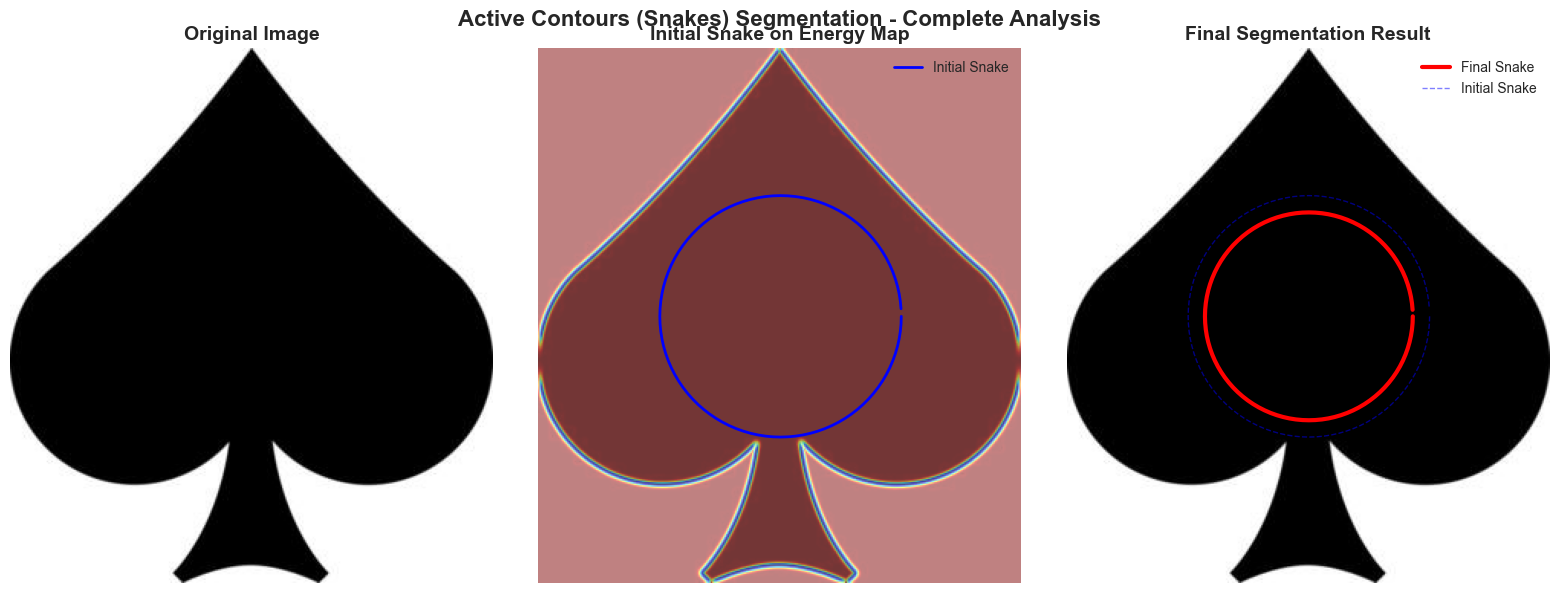

In [16]:
# Final comparison: Best result
print("="*60)
print("ACTIVE CONTOURS (SNAKES) SEGMENTATION - FINAL RESULTS")
print("="*60)
print(f"\nOptimal Parameters:")
print(f"  α (Elasticity):  {alpha}")
print(f"  β (Stiffness):   {beta}")
print(f"  γ (Step size):   {gamma}")
print(f"  Iterations:      {n_iterations}")
print(f"  Snake points:    {n_points}")
print(f"\nEnergy Analysis:")
initial_energy = calculate_internal_energy(initial_snake, alpha, beta)
final_energy = calculate_internal_energy(final_snake, alpha, beta)
print(f"  Initial internal energy: {initial_energy:.2f}")
print(f"  Final internal energy:   {final_energy:.2f}")
print(f"  Energy reduction:        {initial_energy - final_energy:.2f}")
print(f"  Reduction percentage:    {100*(initial_energy - final_energy)/initial_energy:.2f}%")
print("\n" + "="*60)

# Create final visualization
fig = plt.figure(figsize=(16, 6))

# Original image
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(image_rgb)
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

# External energy with initial snake
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(external_energy, cmap='jet', alpha=0.7)
ax2.imshow(image_rgb, alpha=0.3)
ax2.plot(initial_snake[:, 0], initial_snake[:, 1], 'b-', linewidth=2, label='Initial Snake')
ax2.set_title('Initial Snake on Energy Map', fontsize=14, fontweight='bold')
ax2.legend()
ax2.axis('off')

# Final result
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(image_rgb)
ax3.plot(final_snake[:, 0], final_snake[:, 1], 'r-', linewidth=3, label='Final Snake')
ax3.plot(initial_snake[:, 0], initial_snake[:, 1], 'b--', linewidth=1, 
         alpha=0.5, label='Initial Snake')
ax3.set_title('Final Segmentation Result', fontsize=14, fontweight='bold')
ax3.legend()
ax3.axis('off')

plt.suptitle('Active Contours (Snakes) Segmentation - Complete Analysis', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Conclusion

This notebook has successfully demonstrated the implementation and analysis of Active Contours (Snakes) segmentation technique. We have:

1. Loaded and preprocessed images (RGB and Grayscale)
2. Created binary thresholded images
3. Detected contours using built-in functions
4. Implemented internal energy with α and β parameters (user-defined)
5. Constructed the internal energy matrix
6. Analyzed the roles of α and β in detail
7. Demonstrated effects of extreme parameter values
8. Visualized snake evolution over iterations
9. Discussed initialization problems and solutions

The implementation combines both **built-in functions** (OpenCV for contour detection, image processing) and **user-defined functions** (energy calculations, snake evolution algorithm), demonstrating a comprehensive understanding of the Active Contours technique.

---
